<center>

<h1>$\textbf{Correlation Analysis of Salinity Indices & Soil Electrical Conductivity at a 1-meter Depth}$</h1>





$\textit{Name : Ioannis Kontogiorgakis}$<br>
$\textit{Associates : Nikolaos Gerarchakis}$<br>
$\textit{Date : February 9, 2023}$<br>
<br>



<center>

![](https://drive.google.com/uc?export=view&id=13qxDn2dk5xE6U4tZW-zmKBjo95RnTg44)

<h2><b>Abstract</b></h2>

Despite the importance of soil electrical conductivity (EC) in precision agriculture, traditional measurement methods are labor-intensive and time-consuming, requiring farmers to manually survey vast fields. Moreover, the reliance on ground-based measurements limits the scalability and efficiency of soil monitoring efforts. In this project, we aim to develop a new method of measuring Electrical Conductivity by utilizing soil salinity indices.
<br>

<h2><b>Project Objectives</b></h2>

<ol>
<li>Develop a robust regression model which aims to predict soil EC from  UAV-derived salinity indices across agricultural landscapes. </li>

<li>Facilitate the creation of cost-effective management zones through the integration of remote sensing data, enhancing both producer profitability and environmental sustainability.

</ol>
<br>

<h2><b>Dataset</b></h2>


The salinity measurements were acquired from <b>Sentinel-2</b> satellite images via <b>Google Earth</b>. It consists of soil, atmospheric measurements of a specific field in Heraklion, Greece:

<ul>
<li>salinity indices of 01-09-2023</li>
</ul>

In order to create some ground truth data about our target variable "EC", we measured the soil electrical conductivity manually using with a soil EC-meter. The output of this device was the geographical coordinates of a point and the respective EC of that point.

<ul>
<li>The 01-09-2023 dataset(salinity indices as features and EC measurement as target variable) will be used in order to train and select the best model.</li>
</ul>

<br>

<h2><b>Methodology<b><h2>

<center>

![](https://drive.google.com/uc?export=view&id=13CP50Zf6gb6mYFCPhrV44ior8v1wFggs)

</center>


Our Machine Learning pipeline consists of the following steps:
<ul>
<li>Split into Train and Test set with 80/20 ratio.</li>
<li>Use train set to fit the data into a selected model.</li>
<li>Identify best model parameters, using Cross Validation.</li>
<li>Evaluate model using metrics, such as r2, RMSE and MSE.</li>
</ul>


Models to test:
<ul>
<li>Linear Regression (LR)</li>
<li>Random Forest (RF)</li>
<li>XGBoost (XGB)</li>
<li>Simple Neural Network</li>
</ul>


<h2><b> Outcome </b></h2>

<ul>
<li>We introduced a novel approach for measuring Soil Electrical Conductivity that avoids the need for manual tools. </li>
<li>Developed a robust XGB model with an $r^2$ score of <b>0.9788</b>, showcasing its ability to predict soil electrical conductivity (EC) accurately, as shown from the final model visualization.</li>

<li>Achieved a low RMSE of <b>4.6980</b> and MSE of <b>22.0712</b>, indicating the model's precision in estimating EC values.</li>
<li>The model was trained efficiently in just <b>6.06</b> seconds, demonstrating its scalability for large datasets.</li>
</ul>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

# <b>Import necessary libraries and dataset</b>

First, we load all the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler


# Import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor


# Import the NN libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,layers
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
# import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.8 MB/s eta 0:00:00


<br><br>
In order to create initial dataset we used kriging interpolation to the EC measurements to achieve spatial distribution across the field. After, we connected the features obtained by the Sentinel satellite with the target variable EC, in order to create the initial training dataset. Thus, in future we will extrapolate the predicted EC values in order to get the real EC values.

In [15]:
df_01_09 = pd.read_csv(r"/content/drive/MyDrive/agri_project/data/1_FINAL_DATASET_AFTER_KRIGING_INTERPOLATION.csv")
df_01_09

,id,X,Y,EC,BSI,COSRI,CRSI,DI-1,DI-2,DI-3,...,S-6,SAL_RATIO,SAVI,SI-1,SI-2,SI-3,SI-T,SR,SSRI,VSSI
0,1,597403.740,3907525.588,145.454300,0.35132,0.14072,0.65264,1.17116,1.61270,1.32335,...,4681.482910,-0.06794,0.26364,2216.111328,5394.983887,3473.276367,63.120800,1.59447,1.69508,-28872.599609
1,2,597404.073,3907525.588,147.772995,0.35992,0.13926,0.65232,1.17047,1.60672,1.31918,...,4699.143066,-0.06920,0.26068,2229.450684,5412.520996,3494.123047,63.487549,1.58634,1.68826,-28890.095703
2,3,597404.405,3907525.588,150.864594,0.35992,0.13926,0.65232,1.17047,1.60672,1.31918,...,4699.143066,-0.06920,0.26068,2229.450684,5412.520996,3494.123047,63.487549,1.58634,1.68826,-28954.798828
3,4,597404.738,3907525.588,157.047806,0.37713,0.13633,0.65167,NaN,NaN,NaN,...,4733.278809,-0.07171,0.25475,2255.238770,5446.427246,3534.426758,64.196510,1.57004,1.67461,-28900.488281
4,5,597405.070,3907525.588,160.139404,0.38583,0.13486,0.65135,NaN,NaN,NaN,...,4749.958984,-0.07299,0.25175,2267.838623,5462.993164,3554.116699,64.542892,1.56180,1.66771,-28945.779297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37138,37139,597440.312,3907434.824,NaN,0.60244,0.11354,0.61654,NaN,NaN,NaN,...,4922.015625,-0.07570,0.19908,2586.241455,5862.859863,4009.833496,70.786171,1.41683,1.51925,-31326.042969
37139,37140,597440.645,3907434.824,156.274902,0.60368,0.11296,0.61610,NaN,NaN,NaN,...,4924.762695,-0.07606,0.19791,2590.428711,5866.295410,4015.919678,70.934242,1.41388,1.51660,-31321.703125
37140,37141,597440.977,3907434.824,157.047806,0.60368,0.11296,0.61610,NaN,NaN,NaN,...,4924.762695,-0.07606,0.19791,2590.428711,5866.295410,4015.919678,70.934242,1.41388,1.51660,-31356.406250
37141,37142,597440.645,3907434.491,NaN,0.57366,0.11381,0.61566,NaN,NaN,NaN,...,4909.358887,-0.07518,0.19929,2584.759521,5853.399902,4003.730957,70.767113,1.41738,1.51918,-31212.472656


<br><br><br>
# <b>Preprocessing</b>


In this section, we will preprocess the initial dataset, in order to be suitable for our machine learning models. Our data preprocessing pipeline consists of 3 steps:

<ul>
<li>Fill NaN values </li>
<li>Remove dupicates </li>
</ul>

<br><br>
## Fill missing values

We will fill the missing values of the dataset with the mean of each column.

In [16]:
new_df = df_01_09.fillna(df_01_09.mean())
new_df.drop(['id'], axis=1, inplace=True)

Now, let's print the summary of the dataset after filling the missing values

In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37143 entries, 0 to 37142
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          37143 non-null  float64
 1   Y          37143 non-null  float64
 2   EC         37143 non-null  float64
 3   BSI        37143 non-null  float64
 4   COSRI      37143 non-null  float64
 5   CRSI       37143 non-null  float64
 6   DI-1       37143 non-null  float64
 7   DI-2       37143 non-null  float64
 8   DI-3       37143 non-null  float64
 9   DI-4       37143 non-null  float64
 10  EVI        37143 non-null  float64
 11  ISK        37143 non-null  float64
 12  NDSI       37143 non-null  float64
 13  NDVI       37143 non-null  float64
 14  NSI        37143 non-null  float64
 15  S-1        37143 non-null  float64
 16  S-2        37143 non-null  float64
 17  S-3        37143 non-null  float64
 18  S-4        37143 non-null  float64
 19  S-5        37143 non-null  float64
 20  S-6   

As we can see, all columns contain 37143 non-null values, so the dataset is properly filled.

# Exploratory data analysis

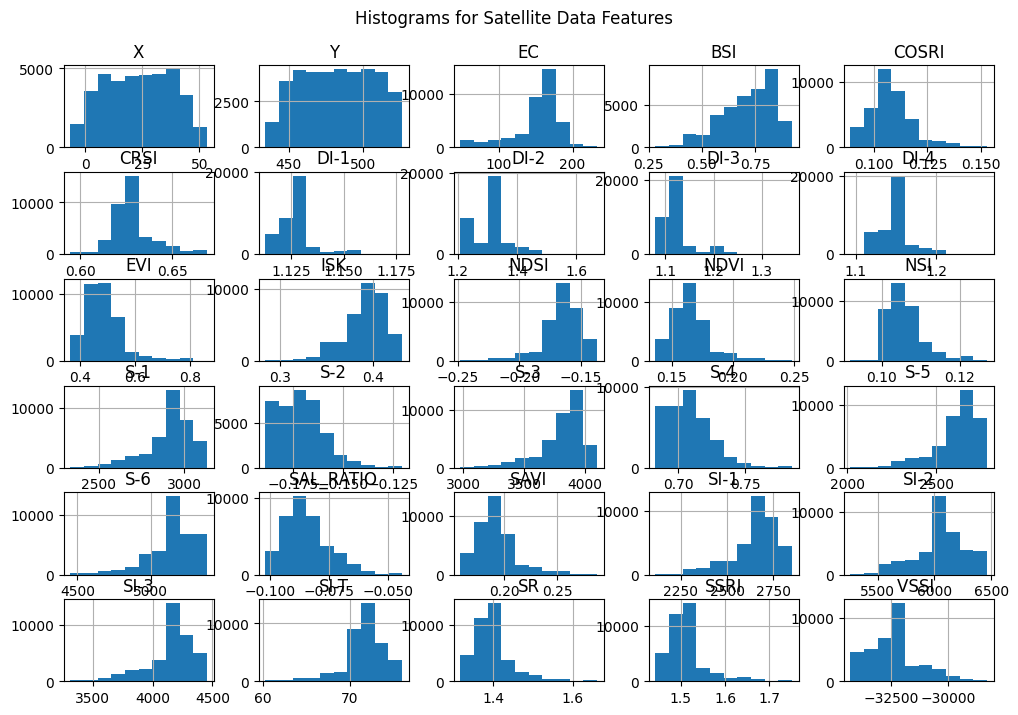

In [18]:
# Plot histograms for all features
new_df.hist(bins=10, figsize=(12, 8))
plt.suptitle("Histograms for Satellite Data Features", y=0.95)
plt.show()

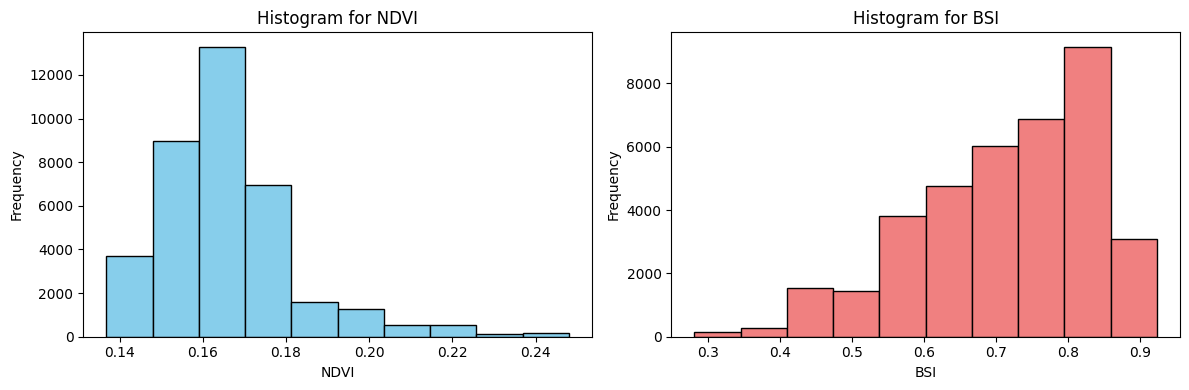

In [19]:
# NDVI, BSI Histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_01_09['NDVI'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram for NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_01_09['BSI'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Histogram for BSI')
plt.xlabel('BSI')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

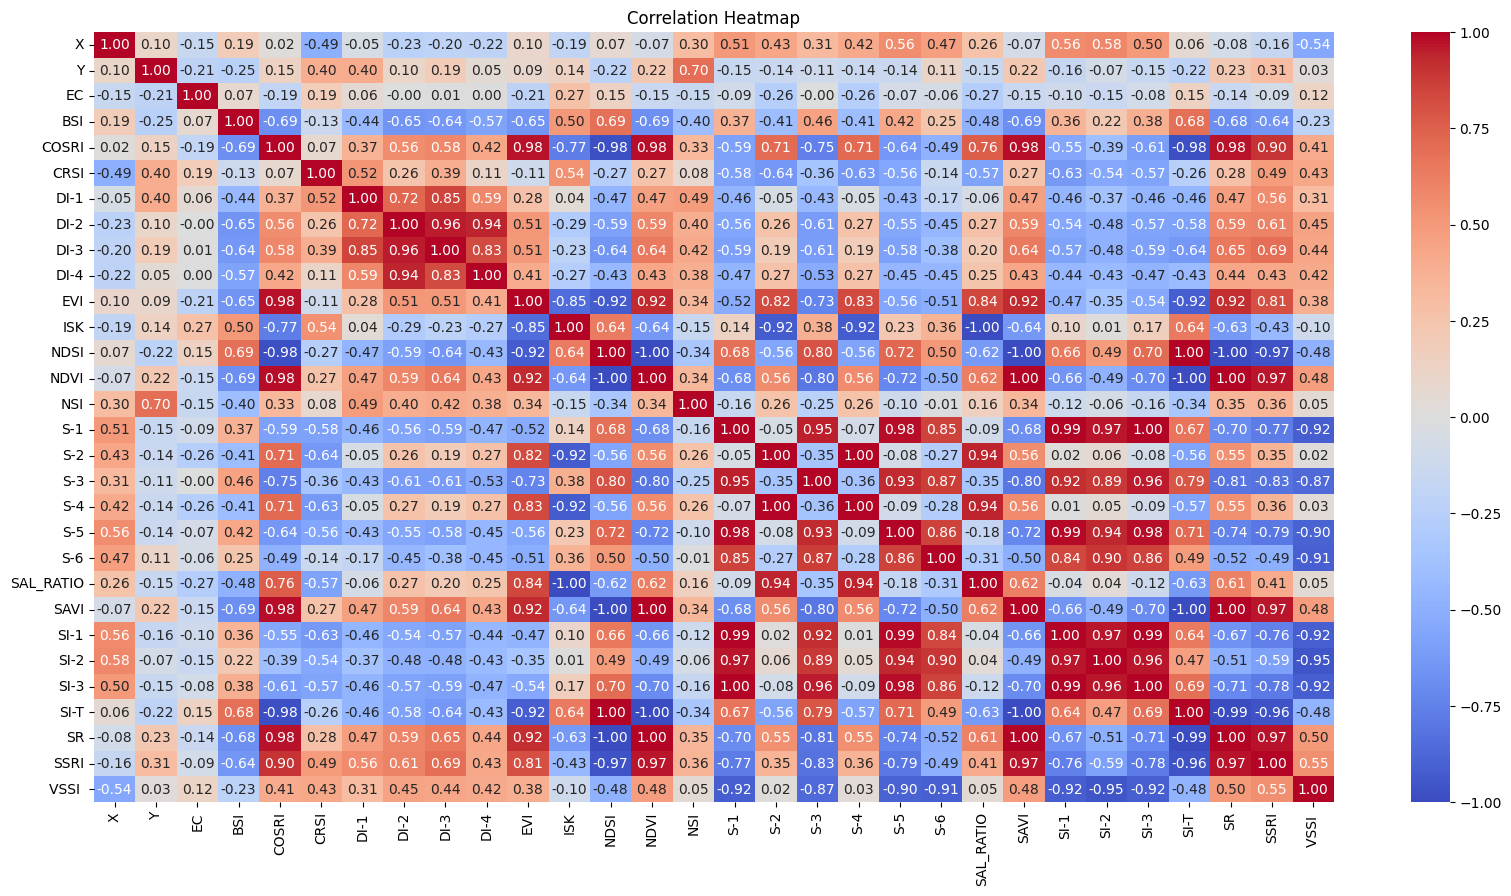

In [20]:
# Correlation Heatmap
correlation_matrix = new_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<br><br>
# <b>Model Selection and Training<b>

## Data Split

First, we will split our data into train set and test set, in ratio 80/20. Train set will be utilized to train the model, while test set will be utilized to evaluate the selected model.

In [21]:
features = new_df.drop(['EC'], axis=1)
target = new_df['EC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

<br><br><br>
## Model Training and Evaluation


In order to select the the best parameters for our model, we will implement model finetuning, using python library GridSearchCV. For that reason we first define a parameter grid for each model. During model finetuning process, we will select the best parameters for each model.

In [ ]:
# Define a parameter grid for each model to search through
RF_param_grid = {
    'n_estimators': [50, 100, 150, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


XGB_param_grid = {
    'n_estimators': [150, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}


CAT_param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 10, 12],
    'l2_leaf_reg': [1, 3, 7]
}

<br><br><br>
Functions for model training and evaluation
<br><br>

In [ ]:
# TODO in future : Function to print explain the importance of the features
# in respect to the model

# def feature_importance(model):
#   # Use the shap library to explain the model predictions
#   explainer = shap.TreeExplainer(model)
#   shap_values = explainer.shap_values(features)

#   # Create a summary plot
#   shap.summary_plot(shap_values, features)

In [22]:
def store_prediction(y_pred):
  """
  Store the predicted values in an Excel file.

  Parameters:
  y_pred (array-like): Predicted values of the target variable.

  Returns:
  None
  """
  # Create a new DataFrame with the predictions and a specified column name
  predictions_df = pd.DataFrame({'EC': y_pred})

  # Save the predictions DataFrame to an Excel file
  # Replace 'output_file.xlsx' with your desired file name and path
  predictions_df.to_excel('/content/drive/MyDrive/agri_project/model_EC_02-09.xlsx', index=False)

In [6]:
def model_finetuning(model_name, X_train, X_test, y_train, y_test):
  """
  Fine-tunes a regression model using grid search with cross-validation.

  Parameters:
  - model_name (str): The name of the regression model ('RF', 'XGB', or 'CAT').
  - X_train (DataFrame): The input features for training the model.
  - X_test (DataFrame): The input features for testing the model.
  - y_train (Series): The target variable for training the model.
  - y_test (Series): The target variable for testing the model.

  Returns:
  - dict: A dictionary containing the best hyperparameters found during the grid search.
  """

  # Create a regression model
  if model_name == 'RF':
    model = RandomForestRegressor(random_state=42)
    model_param_grid = RF_param_grid
  elif model_name == 'XGB':
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model_param_grid = XGB_param_grid
  elif model_name == 'CAT':
    model = CatBoostRegressor(random_state=42)
    model_param_grid = CAT_param_grid


  # Create a GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=model_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)

  # Fit the GridSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best model
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # Print the best parameters
  print(f"{model_name} best Hyperparameters:")
  print(best_params)
  return best_params

In [7]:
def evaluate_model(model, X_test, y_test):
  """
  Evaluates the performance of a regression model using various metrics.

  Parameters:
  - model: The trained regression model.
  - X_test (DataFrame): The input features for testing the model.
  - y_test (Series): The true target variable for testing the model.

  Returns:
  - None
  """
  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)


  r2 = model.score(X_test, y_test)  # R-squared directly from the model
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100



  # Print the results
  print(f"Mean Squared Error: {mse:.4f}")
  print(f"Root Mean Squared Error: {rmse:.4f}")
  print(f"Mean Absolute Error: {mae:.4f}")
  print(f"R-squared: {r2:.4f}")
  print(f"Mean Absolute Percentage Error: {mape:.4f}%")

In [8]:
def train_model(model_name, model_params, X_train, X_test, y_train, y_test):
  """
  Trains a regression model, makes predictions, and evaluates its performance.

  Parameters:
  - model_name (str): The name of the regression model to be trained.
  - model_params (dict): The hyperparameters to be passed to the model.
  - X_train (DataFrame): The input features for training the model.
  - X_test (DataFrame): The input features for testing the model.
  - y_train (Series): The true target variable for training the model.
  - y_test (Series): The true target variable for testing the model.

  Returns:
  - model: The trained regression model.
  - y_pred (array): The predicted target variable.
  - rmse (float): The root mean squared error.
  - mse (float): The mean squared error.
  - r2 (float): The R-squared value.
  """

  if model_name == 'RF':
    model = RandomForestRegressor(**model_params, random_state=42)
  elif model_name == 'XGB':
    model = XGBRegressor(**model_params, random_state=42)
  elif model_name == 'LR':
    model = LinearRegression()
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif model_name == 'CAT':
    model = CatBoostRegressor(**model_params, random_state=42)

  # start timer
  start_time = time.time()

  # Train the model
  model.fit(X_train, y_train)

  # end timer
  end_time = time.time()

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = model.score(X_test, y_test)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

  # Print the results
  print(f"Mean Squared Error: {mse:.4f}")
  print(f"Root Mean Squared Error: {rmse:.4f}")
  print(f"Mean Absolute Error: {mae:.4f}")
  print(f"R-squared: {r2:.4f}")
  print(f"Mean Absolute Percentage Error: {mape:.4f}%")
  print(f"Execution time: {end_time - start_time}")

  return model, y_pred, rmse, mse, r2

In [9]:
def feature_importance(model):
  """
  Calculate and display the feature importances of a trained model.

  Parameters:
  - model (str): The trained regression model.

  Returns:
  - df_feature_importance (DataFrame): DataFrame containing feature names and their importances.
  """
  # Get feature importances
  feature_importances = model.feature_importances_

  # Create a DataFrame to display feature importances
  df_feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
  df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

  # Print the DataFrame
  print(df_feature_importance)
  return df_feature_importance

In [10]:
def predict_new_data(model, X_test, y_test):
  """
  Predict the target variable for new data using a trained regression model and evaluate the predictions.

  Parameters:
  - model (str): The trained regression model.
  - X_test (DataFrame): The feature matrix of the new data.
  - y_test (Series): The true target values of the new data.

  Returns:
  None
  """
  if 'id' in X_test.columns:
    X_test = X_test.drop(['id'],axis=1)
  X_test = X_test.fillna(X_test.mean())
  y_pred = model.predict(X_test)


  print('------------------------------------------')
  print('Test trained model with new data')


  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = model.score(X_test, y_test)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

  # Print the results
  print(f"Mean Squared Error: {mse:.4f}")
  print(f"Root Mean Squared Error: {rmse:.4f}")
  print(f"R-squared: {r2:.4f}")
  print(f"Mean Absolute Error: {mae:.4f}")
  print(f"Mean Absolute Percentage Error: {mape:.4f}%")
  print('------------------------------------------')


<br><br>
Functions used for plots

In [11]:
def plot_actual_pred(model_name, y_pred, y_test,rmse, mse, r2):
  """
  Plot the actual vs. predicted values and display evaluation metrics.

  Parameters:
  - model_name (str): The name of the regression model.
  - y_pred (Series): The predicted target values.
  - y_test (Series): The true target values.
  - rmse (float64): The root mean squared error.
  - mse (float64): The mean squared error.
  - r2 (float64): The R-squared score.

  Returns:
  None
  """
  # Create a DataFrame with actual and predicted values
  results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

  # Plot the predicted vs. actual values
  plt.figure(figsize=(12, 4))
  sns.scatterplot(x='Actual', y='Predicted', data=results_df, color='limegreen')
  plt.title(f'{model_name} : Actual vs. Predicted EC Values')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')

  # Add a diagonal line for reference
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
  plt.text(0.1, 0.8, f'MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR-squared: {r2:.4f}', transform=plt.gca().transAxes)


  plt.legend(loc='lower right')
  plt.show()

In [12]:
def residuals_test(y_pred, y_test):
  """
  Plot residuals against predicted values and the distribution of residuals.

  Parameters:
  - y_pred (Series): The predicted target values.
  - y_test (Series): The true target values.

  Returns:
  None
  """
  # Calculate residuals
  residuals = y_test - y_pred

  # Create a figure with two subplots side by side
  fig, axs = plt.subplots(1, 2, figsize=(10, 4))

  # Plot residuals against predicted values in the first subplot
  sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
  axs[0].set_title('Residual Plot')
  axs[0].set_xlabel('Predicted Values')
  axs[0].set_ylabel('Residuals')
  axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
  axs[0].legend()

  # Plot the distribution of residuals in the second subplot
  sns.histplot(residuals, kde=True, ax=axs[1])
  axs[1].set_title('Distribution of Residuals')
  axs[1].set_xlabel('Residuals')
  axs[1].set_ylabel('Frequency')

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

<br><br><br>
### <b>Linear Regression</b>

Let's train a Linear Regression model.

In [23]:
LR_model, LR_y_pred, LR_rmse, LR_mse, LR_r2 = train_model('LR', {}, X_train, X_test, y_train, y_test)

Mean Squared Error: 717.8734
Root Mean Squared Error: 26.7932
Mean Absolute Error: 18.9986
R-squared: 0.3117
Mean Absolute Percentage Error: 16.4336%
Execution time: 0.1288154125213623


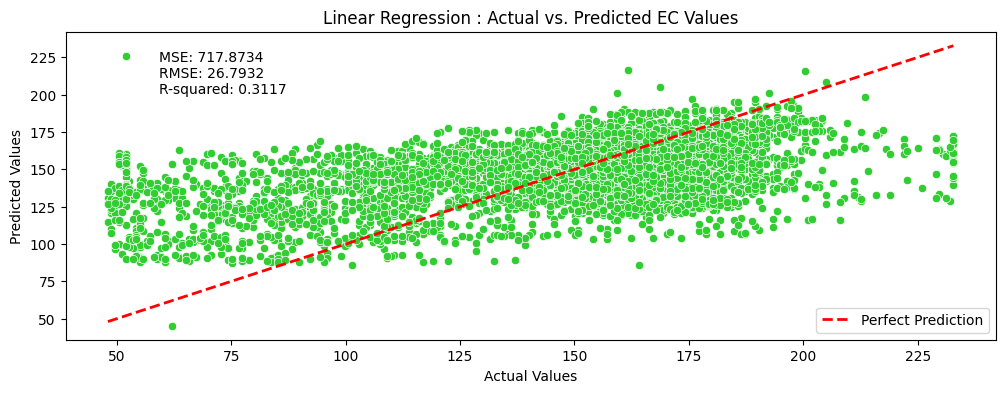

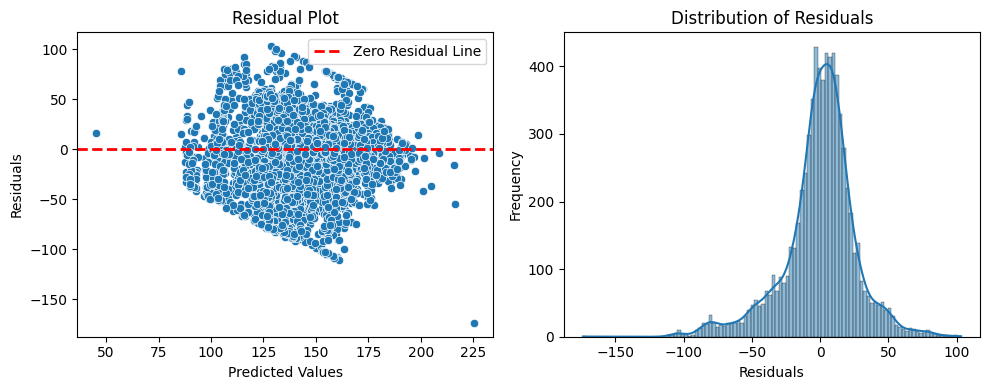

In [24]:
# Evaluate RF model with different plots
plot_actual_pred('Linear Regression', LR_y_pred, y_test, LR_rmse, LR_mse, LR_r2)
residuals_test(LR_y_pred, y_test)

<br><br><br>
### <b>Random Forest</b>

In [25]:
# Compute best parameters for the Random Forest Regressor with model finetuning
# For the specified models, I have already perfomed model finetuning, so best parameters are the following
# RF_best_params = model_finetuning('RF', X_train, X_test, y_train, y_test)

RF_best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RF_model, RF_y_pred, RF_rmse, RF_mse, RF_r2 = train_model('RF', RF_best_params, X_train, X_test, y_train, y_test)

Mean Squared Error: 27.9758
Root Mean Squared Error: 5.2892
Mean Absolute Error: 3.0225
R-squared: 0.9732
Mean Absolute Percentage Error: 2.3926%
Execution time: 93.6404869556427


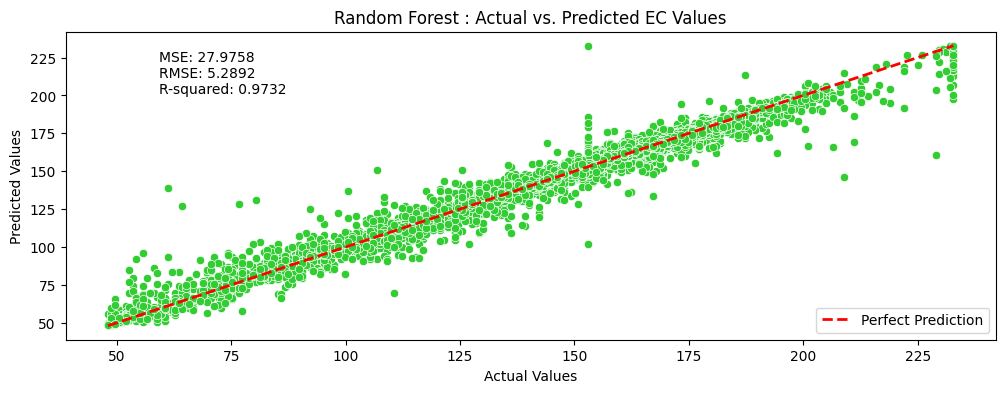

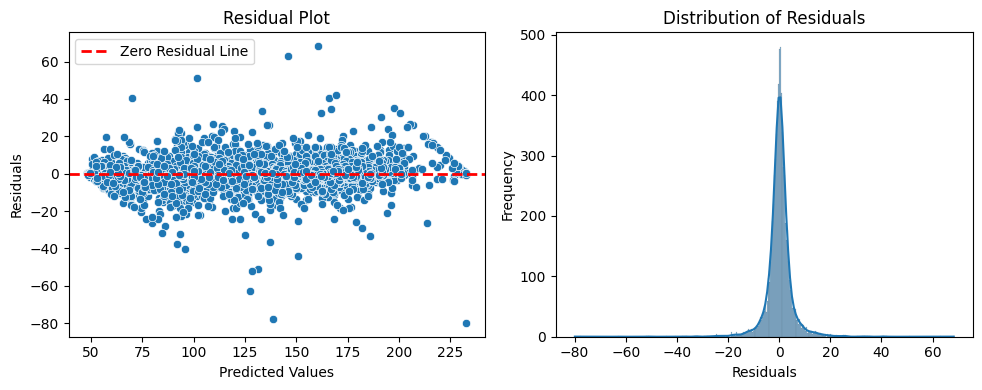

In [26]:
# Evaluate RF model with different plots
plot_actual_pred('Random Forest', RF_y_pred, y_test, RF_rmse, RF_mse, RF_r2)
residuals_test(RF_y_pred, y_test)

<br><br><br>
### <b>XGBoost</b>



In [27]:
# Compute best parameters for the XGBoost Regressor with model finetuning
# XGB_best_params = model_finetuning('XGB', X_train, X_test, y_train, y_test)
# XGB_best_params = {'objective':'reg:squarederror','learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 1000}
XGB_best_params = {'objective':'reg:squarederror','learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000}
XGB_model, XGB_y_pred, XGB_rmse, XGB_mse, XGB_r2 = train_model('XGB', XGB_best_params, X_train, X_test, y_train, y_test)

Mean Squared Error: 26.2199
Root Mean Squared Error: 5.1205
Mean Absolute Error: 3.2245
R-squared: 0.9749
Mean Absolute Percentage Error: 2.4806%
Execution time: 11.109840869903564


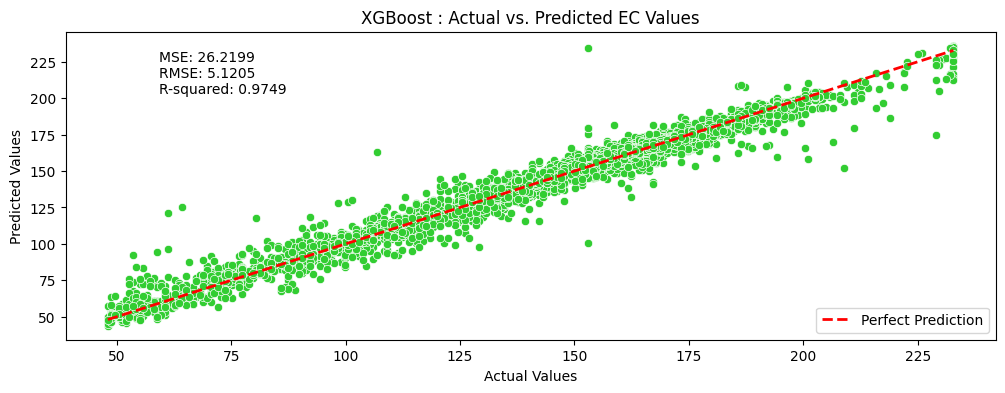

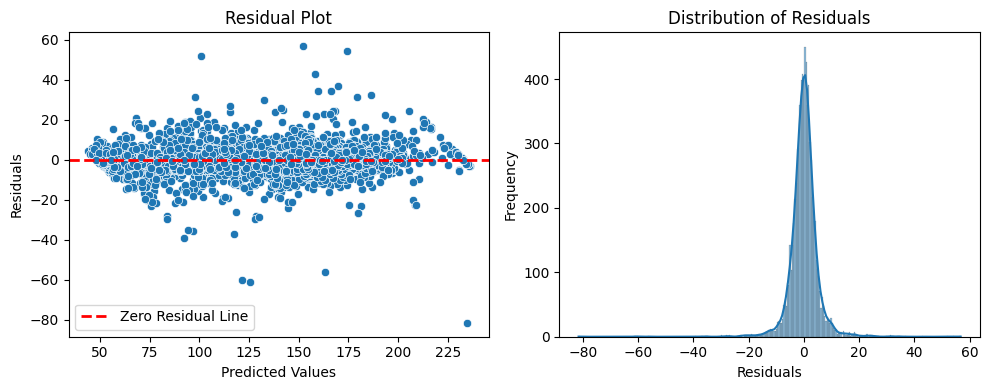

In [28]:
# Evaluate RF model with different plots
plot_actual_pred('XGBoost', XGB_y_pred, y_test, XGB_rmse, XGB_mse, XGB_r2)
residuals_test(XGB_y_pred, y_test)

<br><br><br>
### TODO in future : <b>CatBoost Regression</b>
Due to excessive excecution time and limited resources, CatBoost regression was not executed.

In [ ]:
# Compute best parameters for the Catboost Regressor with model finetuning
CAT_best_params = model_finetuning('CAT', X_train, X_test, y_train, y_test)
# LogR_best_params = {}
CAT_model, CAT_y_pred, CAT_rmse, CAT_mse, CAT_r2 = train_model('CAT', CAT_best_params, X_train, X_test, y_train, y_test)

<br><br><br>
### <b>Simple Neural Network</b>

In [29]:
# Define custom R-squared metric using TensorFlow operations
def r2(y_true, y_pred):
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    r2 = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
    return r2

# Define custom RMSE metric using TensorFlow operations
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

In [30]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Define the neural network model
model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2,'mse',rmse, 'mae','mape'])

In [32]:
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
743/743 [==============================] - 7s 7ms/step - loss: 1301.3542 - r2: -0.4649 - mse: 1301.3542 - rmse: 28.9066 - mae: 22.3732 - mape: 17.4802 - val_loss: 458.3855 - val_r2: 0.4795 - val_mse: 458.3855 - val_rmse: 21.0895 - val_mae: 15.1167 - val_mape: 12.6440
Epoch 2/100
743/743 [==============================] - 7s 9ms/step - loss: 447.5144 - r2: 0.4973 - mse: 447.5144 - rmse: 20.7004 - mae: 14.7729 - mape: 12.3011 - val_loss: 386.2644 - val_r2: 0.5540 - val_mse: 386.2644 - val_rmse: 19.1924 - val_mae: 13.4965 - val_mape: 10.7521
Epoch 3/100
743/743 [==============================] - 5s 7ms/step - loss: 417.1391 - r2: 0.5417 - mse: 417.1391 - rmse: 19.9582 - mae: 14.2338 - mape: 11.7751 - val_loss: 389.7098 - val_r2: 0.5455 - val_mse: 389.7098 - val_rmse: 19.3412 - val_mae: 14.0447 - val_mape: 11.1872
Epoch 4/100
743/743 [==============================] - 6s 8ms/step - loss: 390.2230 - r2: 0.5681 - mse: 390.2230 - rmse: 19.2930 - mae: 13.7505 - mape: 11.3305 - val_

In [33]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test_scaled, y_test)

233/233 [==============================] - 1s 3ms/step - loss: 119.1212 - r2: 0.8625 - mse: 119.1212 - rmse: 10.2796 - mae: 6.6453 - mape: 5.0674


<br><br>
# <b>Experiment :</b> Significant features

In this section, we aim to investigate the impact of using only the most significant features derived from the best-performing models on the overall training time and resource consumption. For these experiments we monitor the perfomance of XGBoost and Random Forest model.

In [34]:
# calculate feature importance for the XGBoost model
best_XGB_model = XGBRegressor(**XGB_best_params, random_state=42).fit(X_train, y_train)
significant_features = feature_importance(best_XGB_model)

      Feature  Importance
13        NSI    0.346344
4        CRSI    0.164724
15        S-2    0.096601
27       SSRI    0.075605
5        DI-1    0.063137
22       SI-1    0.039052
0           X    0.020496
20  SAL_RATIO    0.017403
18        S-5    0.016842
2         BSI    0.016627
1           Y    0.016000
17        S-4    0.012960
16        S-3    0.012890
9         EVI    0.011426
10        ISK    0.010070
7        DI-3    0.009312
19        S-6    0.008968
23       SI-2    0.007885
11       NDSI    0.007006
24       SI-3    0.006654
3       COSRI    0.006128
12       NDVI    0.006089
26         SR    0.006004
25       SI-T    0.005907
8        DI-4    0.005335
14        S-1    0.004019
6        DI-2    0.003117
28      VSSI     0.002163
21       SAVI    0.001233


<br><br>
## K=20 most significant features


In [35]:
top_20_features = significant_features.head(20)['Feature'].tolist()

# isolate the rows from the top features
X_train_top_20 = X_train[top_20_features]
X_test_top_20 = X_test[top_20_features]

In [36]:
print('Train the best XGBoost model using only the 20 most significant features')
print('------------------------------------------------------------------------')

# train the best XGB model with the significant features
XGB_model_top_20, XGB_y_pred_top_20, XGB_rmse_top_20, XGB_mse_top_20, XGB_r2_top_20 = train_model('XGB', XGB_best_params, X_train_top_20, X_test_top_20, y_train, y_test)

Train the best XGBoost model using only the 20 most significant features
------------------------------------------------------------------------
Mean Squared Error: 23.5654
Root Mean Squared Error: 4.8544
Mean Absolute Error: 3.0136
R-squared: 0.9774
Mean Absolute Percentage Error: 2.3008%
Execution time: 7.00957989692688


<br>
Lets do the same with the Random Forest model

In [37]:
print('Train the best Random Forest model using only the 20 most significant features')
print('------------------------------------------------------------------------------')

# train the model with the significant features
RF_model_top_20, RF_y_pred_top_20, RF_rmse_top_20, RF_mse_top_20, RF_r2_top_20 = train_model('RF', RF_best_params, X_train_top_20, X_test_top_20, y_train, y_test)

Train the best Random Forest model using only the 20 most significant features
------------------------------------------------------------------------------
Mean Squared Error: 22.3716
Root Mean Squared Error: 4.7299
Mean Absolute Error: 2.6535
R-squared: 0.9786
Mean Absolute Percentage Error: 2.0929%
Execution time: 62.71978163719177


<br><br>
## K=15 most significant features

In [38]:
top_15_features = significant_features.head(15)['Feature'].tolist()

# isolate the rows from the top features
X_train_top_15 = X_train[top_15_features]
X_test_top_15 = X_test[top_15_features]

In [39]:
print('Train the best XGBoost model using only the 15 most significant features')
print('------------------------------------------------------------------------')

# train the best XGB model with the significant features
XGB_model_top_15, XGB_y_pred_top_15, XGB_rmse_top_15, XGB_mse_top_15, XGB_r2_top_15 = train_model('XGB', XGB_best_params, X_train_top_15, X_test_top_15, y_train, y_test)

Train the best XGBoost model using only the 15 most significant features
------------------------------------------------------------------------
Mean Squared Error: 22.0712
Root Mean Squared Error: 4.6980
Mean Absolute Error: 2.9396
R-squared: 0.9788
Mean Absolute Percentage Error: 2.2319%
Execution time: 5.655998468399048


In [40]:
print('Train the best Random Forest model using only the 15 most significant features')
print('------------------------------------------------------------------------------')

top_15_features = significant_features.head(15)['Feature'].tolist()

# isolate the rows from the top features
X_train_top_15 = X_train[top_15_features]
X_test_top_15 = X_test[top_15_features]

# train the model with the significant features
RF_model_top_15, RF_y_pred_top_15, RF_rmse_top_15, RF_mse_top_15, RF_r2_top_15 = train_model('RF', RF_best_params, X_train_top_15, X_test_top_15, y_train, y_test)

Train the best Random Forest model using only the 15 most significant features
------------------------------------------------------------------------------
Mean Squared Error: 20.9503
Root Mean Squared Error: 4.5771
Mean Absolute Error: 2.5396
R-squared: 0.9799
Mean Absolute Percentage Error: 2.0017%
Execution time: 47.583802223205566


<br><br>
## K=10 most significant features

In [41]:
top_10_features = significant_features.head(10)['Feature'].tolist()

# isolate the rows from the top features
X_train_top_10 = X_train[top_10_features]
X_test_top_10 = X_test[top_10_features]

In [42]:
print('Train the best XGBoost model using only the 10 most significant features')
print('------------------------------------------------------------------------')

# train the best XGB model with the significant features
XGB_model_top_10, XGB_y_pred_top_10, XGB_rmse_top_10, XGB_mse_top_10, XGB_r2_top_10 = train_model('XGB', XGB_best_params, X_train_top_10, X_test_top_10, y_train, y_test)

Train the best XGBoost model using only the 10 most significant features
------------------------------------------------------------------------
Mean Squared Error: 90.8991
Root Mean Squared Error: 9.5341
Mean Absolute Error: 5.7136
R-squared: 0.9128
Mean Absolute Percentage Error: 4.4388%
Execution time: 4.017234563827515


In [43]:
print('Train the best Random Forest model using only the 10 most significant features')
print('------------------------------------------------------------------------------')

# train the model with the significant features
RF_model_top_10, RF_y_pred_top_10, RF_rmse_top_10, RF_mse_top_10, RF_r2_top_10 = train_model('RF', RF_best_params, X_train_top_10, X_test_top_10, y_train, y_test)

Train the best Random Forest model using only the 10 most significant features
------------------------------------------------------------------------------
Mean Squared Error: 87.5179
Root Mean Squared Error: 9.3551
Mean Absolute Error: 5.2047
R-squared: 0.9161
Mean Absolute Percentage Error: 4.0830%
Execution time: 29.958710432052612


<br><br>
## Drone features

In this section, we aim to investigate the impact of using only the features that can be derived from drone flights, since these features are more accurate and sharper than the ones derived from the satelite. These features are:

<ul>
<li>SI-2</li>
<li>S-1</li>
<li>S-6</li>
<li>NDSI</li>
<li>VSSI</li>
<li>SSRI</li>
<li>DI-3</li>
<li>NDVI</li>
</ul>

In [44]:
drone_features = ['SI-2','S-1','S-6','ISK','NDSI','VSSI ','SSRI','DI-3']

# isolate the rows from the drone features
X_train_drone = X_train[drone_features]
X_test_drone = X_test[drone_features]

In [45]:
print('Train the best XGBoost model using only drone features')
print('------------------------------------------------------')

# train the best XGB model with the significant features
XGB_model_drone, XGB_y_pred_drone, XGB_rmse_drone, XGB_mse_drone, XGB_r2_drone = train_model('XGB', XGB_best_params, X_train_drone, X_test_drone, y_train, y_test)

Train the best XGBoost model using only drone features
------------------------------------------------------
Mean Squared Error: 303.0518
Root Mean Squared Error: 17.4084
Mean Absolute Error: 10.2306
R-squared: 0.7094
Mean Absolute Percentage Error: 8.6229%
Execution time: 6.223157644271851


In [46]:
print('Train the best Random Forest model using only drone features')
print('------------------------------------------------------------')

# train the model with the significant features
RF_model_drone, RF_y_pred_drone, RF_rmse_drone, RF_mse_drone, RF_r2_drone = train_model('RF', RF_best_params, X_train_drone, X_test_drone, y_train, y_test)

Train the best Random Forest model using only drone features
------------------------------------------------------------
Mean Squared Error: 266.6023
Root Mean Squared Error: 16.3280
Mean Absolute Error: 9.4972
R-squared: 0.7444
Mean Absolute Percentage Error: 7.9713%
Execution time: 31.896342277526855


<br><br>
## Results

In the context of predicting soil electrical conductivity (EC), Linear Regression (LR) failed to perform as well as XGB and RF due to its inherent limitations in handling non-linear relationships and complex interactions among features. Soil EC can be influenced by various factors, which LR might struggle to capture effectively. Despite its simplicity, the basic neural network model, lacking the complexity and adaptability of XGB and RF, failed to capture the intricate relationships present in the soil EC prediction problem.

On the other hand, XGB (Extreme Gradient Boosting) and RF (Random Forest) models are more flexible and capable of capturing non-linear patterns in the data. XGB, in particular, uses a boosting technique that sequentially adds decision trees to the model, focusing on areas where the model performs poorly, thus improving its accuracy. RF, by aggregating multiple decision trees and considering random subsets of features, is robust to overfitting and can handle high-dimensional data effectively.

The plots depicting Actual vs. Predicted values, Residuals, and the Distribution of Residuals reveal compelling insights into the performance of the XGB and RF models. Both XGB and RF predictions closely align with the perfect prediction line, indicating their efficacy in capturing the underlying patterns in the data. Furthermore, the residuals are concentrated around zero, suggesting minimal bias and a balanced model. The Gaussian distribution of residuals, centered around zero, corroborates the models' goodness of fit, reinforcing their reliability in predicting soil electrical conductivity.
<br><br>
$$
\begin{aligned}
& \text {Table 1.1. XGB model performance for different number of features. }\\
&\begin{array}{cccc}
\hline \hline \text { #Features } & \text { $r^2$ } & \text { RMSE } & \text{MSE}  & \text { Time(s) }\\
\hline 27 & 0.9749 & 5.1205 & 26.2199 & 17.09  \\
20 & 0.9774 & 4.8544 & 23.5654 & 16.29  \\
15 & 0.9788 & 4.6980 & 22.0712 & 6.06  \\
10 & 0.9128 & 9.5341 & 90.8991 & 3.97  \\
8 & 0.7444 & 16.3280 & 266.6023 & 2.77  \\
\hline
\end{array}
\end{aligned}
$$
<br><br>
$$
\begin{aligned}
& \text {Table 1.2. RF model performance for different number of features. }\\
&\begin{array}{cccc}
\hline \hline \text { #Features } & \text { $r^2$ } & \text { RMSE } & \text{MSE}  & \text{Time (s)}\\
\hline 27 & 0.9732 & 5.2892 & 27.9758 & 93.98  \\
20 & 0.9786 & 4.7299 & 22.3716 & 69.52  \\
15 & 0.9799 & 4.5771 & 20.9503 & 50.48  \\
10 & 0.9161 & 9.3551 & 87.5179 & 38.18  \\
8 & 0.7094 & 17.4084 & 266.6023 & 11.78  \\
\hline
\end{array}
\end{aligned}
$$

<br><br>
Overall, the models performance results on Table 1.1 and Table 1.2 suggest that reducing the number of features, specifically to 15, leads to improved model performance in terms of accuracy and computational efficiency. This aligns with the project's purpose of correlating satellite-derived salinity indices with ground-based EC measurements to predict EC more efficiently. By selecting a subset of informative features, both models can achieve comparable or even better performance while reducing computational burden and potentially simplifying the interpretation of the model.



<br><br><br>
## Final Model

Mean Squared Error: 22.0712
Root Mean Squared Error: 4.6980
Mean Absolute Error: 2.9396
R-squared: 0.9788
Mean Absolute Percentage Error: 2.2319%
Execution time: 8.758159875869751


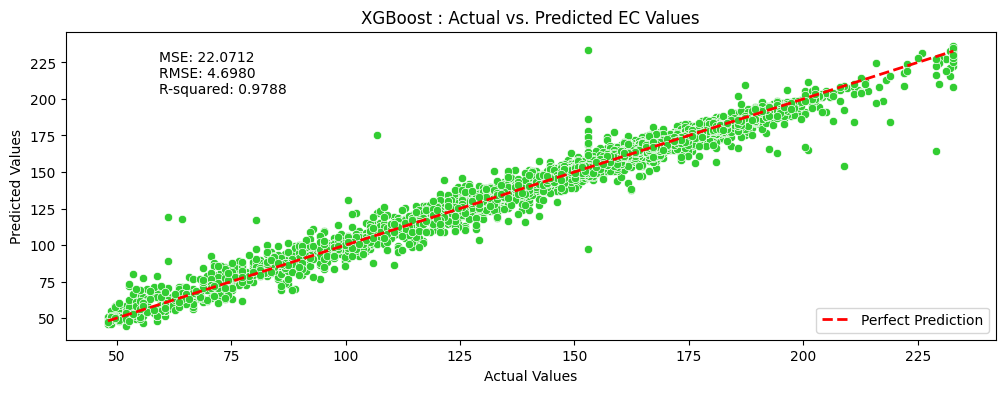

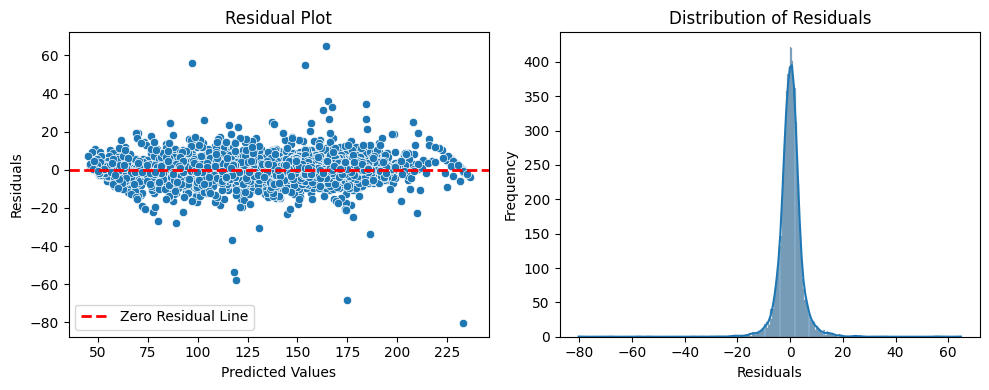

In [47]:
XGB_best_params = {'objective':'reg:squarederror','learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000}
XGB_model, XGB_y_pred, XGB_rmse, XGB_mse, XGB_r2 = train_model('XGB', XGB_best_params, X_train_top_15, X_test_top_15, y_train, y_test)
plot_actual_pred('XGBoost', XGB_y_pred, y_test, XGB_rmse, XGB_mse, XGB_r2)
residuals_test(XGB_y_pred, y_test)